# Models for PM10 

In this notebook, we develop the models for the transformed dataset considering the exogenous variable to be the **PM10**.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import os
import tqdm
from utilities import Utilities

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# models 
from sklearn.linear_model import ElasticNetCV, ElasticNet, LinearRegression
import statsmodels.api as sm
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor

# others
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures

from scipy.stats import jarque_bera

## Definitions for the notebook

In [4]:
# For local folder
IMAGES_FOLDER = "../notes/images/"
# For Google colab
#IMAGES_FOLDER = "drive/MyDrive/Arquivos Acadêmicos/Disciplinas FGV/Machine Learning/images/"

# For local folder
location = "../data/"
# For Google colab
#location = "drive/MyDrive/Arquivos Acadêmicos/Disciplinas FGV/Machine Learning/"

sns.set()

pd.set_option('precision', 3)
pd.options.mode.chained_assignment = None

utility = Utilities()

%matplotlib inline

## Importing the dataset

In [5]:
air_data = pd.read_csv(location + "RiodeJaneiro_MonitorAr_hourly_p3.csv", index_col = 0)
air_data.weekend = air_data.weekend.astype(int)
air_data = air_data.reset_index().drop(columns="index")
air_data.head()

,year,month,day,CodNum,Lat,Lon,Chuva,Pres,RS,Temp,...,CO_lag24,CO_MA24,O3_lag1,O3_lag2,O3_lag24,O3_MA24,PM10_lag1,PM10_lag2,PM10_lag24,PM10_MA24
0,2011,1,2,1,-22.965,-43.180,3.617,-1.530,-1.128,-0.140,...,-0.763,-0.936,-0.738,-0.543,-1.190,-0.365,0.101,0.078,0.087,0.082
1,2011,1,2,7,-22.898,-43.222,-0.272,-1.513,-0.565,0.560,...,-1.678,-1.232,-0.612,-0.997,-0.724,-0.187,-0.307,-0.967,-1.858,-1.136
2,2011,1,2,3,-22.908,-43.178,3.617,-1.557,-0.720,-0.470,...,-0.634,-0.166,-0.211,-0.717,-0.169,-0.027,-0.677,-0.677,-1.617,-1.141
3,2011,1,2,8,-22.925,-43.233,3.617,-1.909,-0.194,-1.068,...,-0.897,-1.283,-0.267,-0.184,-1.028,0.274,-0.773,-0.583,0.495,-1.061
4,2011,1,2,7,-22.898,-43.222,3.617,-1.658,-0.567,0.548,...,-1.591,-1.206,-1.300,-0.612,-1.099,-0.204,-0.484,-0.307,-0.967,-1.136


## Inverse Power Transformation 

Just for future transformations on ozone data. 

In [6]:
air_data_ = pd.read_csv(location + "RiodeJaneiro_MonitorAr_hourly_p2.csv", index_col = 0)

gases = ['CO', 'O3', 'PM10']

pt_gases = {key: PowerTransformer(method = 'yeo-johnson', 
                                  standardize=True).fit(air_data_[[key]]) for key in gases}

del air_data_

## Train and Test

In [7]:
df_train = air_data[air_data.train].drop(columns='train')
df_test = air_data[~air_data.train].drop(columns='train')

x_train = df_train.drop(columns=["O3", 'CO', 'PM10', 'aiq', 'Lat', 'Lon'])
x_test = df_test.drop(columns=["O3", 'CO', 'PM10', 'aiq', 'Lat', 'Lon'])

## Tijuca station

The chosen station to report more detailed results.

In [8]:
x_train_SP = x_train[x_train.CodNum == 8].drop(columns="CodNum")
x_test_SP = x_test[x_test.CodNum == 8] .drop(columns="CodNum")

y_train_pm10 = df_train[df_train.CodNum==8].PM10
y_test_pm10 = df_test[df_test.CodNum==8].PM10

del df_train, df_test

## Linear regression

In [78]:
x_train_SP_sm = sm.add_constant(x_train_SP)
x_test_SP_sm = sm.add_constant(x_test_SP)

reg = sm.OLS(y_train_pm10, x_train_SP_sm)
resl = reg.fit()
print(resl.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     9337.
Date:                seg, 21 jun 2021   Prob (F-statistic):               0.00
Time:                        19:56:28   Log-Likelihood:                -26989.
No. Observations:               54290   AIC:                         5.403e+04
Df Residuals:                   54263   BIC:                         5.427e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.5687      2.886      7.128      0.0

In [79]:
y_pred = resl.predict(x_test_SP_sm)

y_train_pred = resl.predict(x_train_SP_sm)

r2_train = r2_score(y_train_pm10, y_train_pred)
r2_test  = r2_score(y_test_pm10, y_pred)
mae_train = mean_absolute_error(y_train_pm10, y_train_pred)
mae_test  = mean_absolute_error(y_test_pm10, y_pred)
rmse_train = mean_squared_error(y_train_pm10, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_pm10, y_pred, squared = False)

utility.save_metrics("PM10", 8, "simple_linear_regression", {},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8173038270204716
MAE train set: 0.2967484427772395
RMSE train set: 0.39779593990318124
R2 test set: 0.795396593880837
MAE test set: 0.25062012218985036
RMSE test set: 0.32522489750399275


Let's look at the residuals

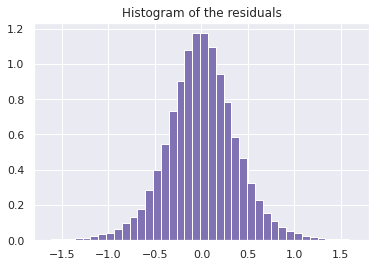

In [80]:
residuals = y_train_pred - y_train_pm10
plt.hist(residuals, bins = 100, density = True, color = 'm')
plt.xlim((-1.8,1.8))
plt.title("Histogram of the residuals")
plt.savefig(IMAGES_FOLDER+"histogram_residuals_pm10_slr.eps", bbox_inches = 'tight')
plt.show()

In [12]:
print("Skew: {}".format(residuals.skew()))
print("Kurt: {}".format(residuals.kurt()))
print("Jarque-Bera: {}".format(jarque_bera(residuals)))

Skew: -0.059770026623621984
Kurt: 3.2764633151058686
Jarque-Bera: Jarque_beraResult(statistic=24310.156098155254, pvalue=0.0)


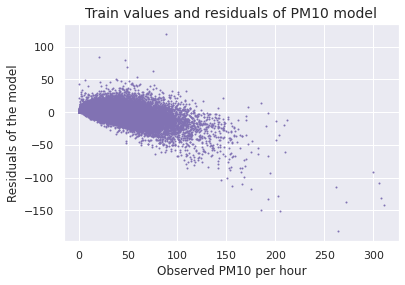

In [81]:
train_trans = pt_gases['PM10'].inverse_transform(y_train_pm10.values.reshape(-1,1))
pred_trans = pt_gases['PM10'].inverse_transform(y_train_pred.values.reshape(-1,1))
residuals = pred_trans - train_trans

plt.scatter(train_trans, residuals, s=1, color='m')
plt.xlabel("Observed PM10 per hour")
plt.ylabel("Residuals of the model")
plt.title("Train values and residuals of PM10 model", fontsize = 14)
plt.savefig(IMAGES_FOLDER+"observed-vs-residuals-pm10-linear-regression.eps", bbox_inches = 'tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


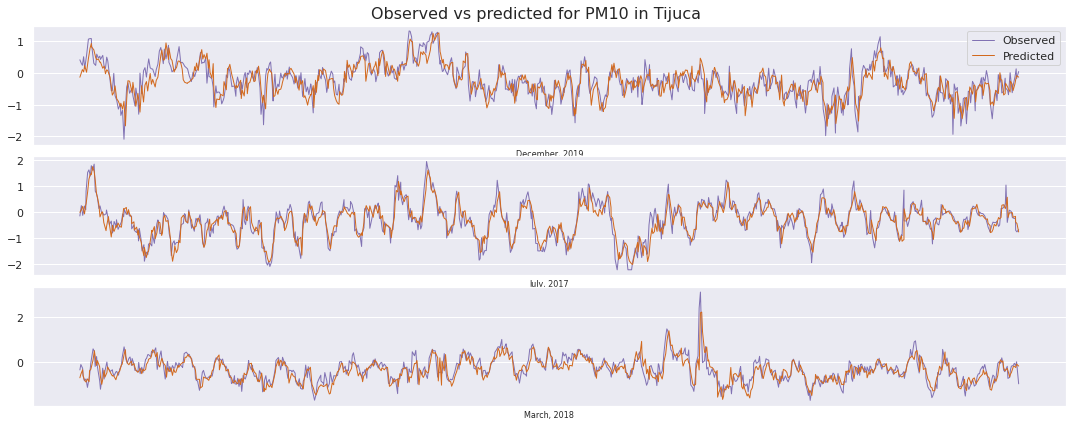

In [16]:
rows1 = x_test_SP[(x_test_SP.year==2019)&(x_test_SP.month==12)]
rows2 = x_test_SP[(x_test_SP.year==2017)&(x_test_SP.month==7)]
rows3 = x_test_SP[(x_test_SP.year==2018)&(x_test_SP.month==3)]

fig, ax = plt.subplots(3,1,figsize = (15,6))

ax[0].plot(rows1.index, y_test_pm10[rows1.index], linewidth = 1, label = 'Observed', color = 'm')
ax[0].plot(rows1.index, y_pred[rows1.index], linewidth = 1, label = 'Predicted', color = 'chocolate')
ax[1].plot(rows2.index, y_test_pm10[rows2.index], linewidth = 1, color = 'm')
ax[1].plot(rows2.index, y_pred[rows2.index], linewidth = 1, color = 'chocolate')
ax[2].plot(rows3.index, y_test_pm10[rows3.index], linewidth = 1, color = 'm')
ax[2].plot(rows3.index, y_pred[rows3.index], linewidth = 1, color = 'chocolate')

ax[0].set_xticks([], minor=False)
ax[1].set_xticks([], minor=False)
ax[2].set_xticks([], minor=False)

fig.suptitle("Observed vs predicted for PM10 in Tijuca", fontsize = 16)
fig.tight_layout(rect=[0, 0.03, 1, 1.02])

ax[0].set_xlabel("December, 2019", fontsize = 8)
ax[1].set_xlabel("July, 2017", fontsize = 8)
ax[2].set_xlabel("March, 2018", fontsize = 8)

ax[0].legend()

plt.savefig(IMAGES_FOLDER+"observed-fitting-pm10-tijuca.eps", bbox_inches='tight')
del rows1,rows2,rows3

In [17]:
x_train_SP_sm = sm.add_constant(x_train_SP.drop(columns=['O3_lag1','CO_lag1','PM10_lag1',
                                                       'O3_lag2','CO_lag2','PM10_lag2',
                                                        'O3_lag24','CO_lag24','PM10_lag24',
                                                       'O3_MA24','CO_MA24','PM10_MA24']))
x_test_SP_sm = sm.add_constant(x_test_SP.drop(columns=['O3_lag1','CO_lag1','PM10_lag1',
                                                       'O3_lag2','CO_lag2','PM10_lag2', 
                                                       'O3_lag24','CO_lag24','PM10_lag24',
                                                       'O3_MA24','CO_MA24','PM10_MA24']))
test_values = [1,2,4,8,12,24,36,48,60,72,84,108]
r2_test_values = []

for i in test_values:
    
    x_train_SP_sm["PM10_lag"] = y_train_pm10.shift(i)
    x_test_SP_sm["PM10_lag"] = y_test_pm10.shift(i)

    x_train_SP_sm.dropna(inplace=True)
    x_test_SP_sm.dropna(inplace=True)
    y_train_pm10_ = y_train_pm10[i:]
    y_test_pm10_ = y_test_pm10[i:]

    res = sm.OLS(y_train_pm10_, x_train_SP_sm).fit()
    y_pred = res.predict(x_test_SP_sm)

    r2_test_values.append(r2_score(y_test_pm10_, y_pred))

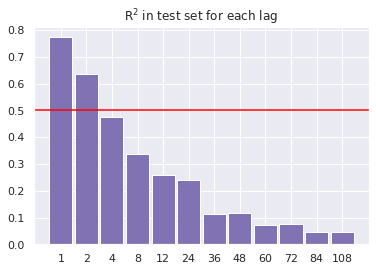

In [18]:
plt.bar([str(i) for i in test_values], r2_test_values, width = 0.9, color = 'm')
plt.axhline(0.5, color = 'red')
plt.title(r"R$^2$ in test set for each lag")
plt.savefig(IMAGES_FOLDER+"r2_test_per_lag_pm10.eps")
plt.show()

## Elastic-net Regression

For this model, polynomial and interaction terms can be added. This is due to the regularization term.

In [19]:
poly = PolynomialFeatures(2)

x_train_SP_poly = pd.DataFrame(poly.fit_transform(x_train_SP), 
                               columns = poly.get_feature_names(x_train_SP.columns), 
                               index = x_train_SP.index)
x_test_SP_poly = pd.DataFrame(poly.fit_transform(x_test_SP), 
                              columns = poly.get_feature_names(x_test_SP.columns),
                              index = x_test_SP.index)

In [21]:
model = ElasticNetCV(l1_ratio = [0.1, 0.2, 0.4, 0.5, 0.7, 0.8, 0.9, 1.0],
                     alphas = range(1, 20), 
                     cv = 5, 
                     n_jobs = 2)

model.fit(x_train_SP_poly, y_train_pm10)

y_pred = model.predict(x_test_SP_poly)

y_train_pred = model.predict(x_train_SP_poly)

r2_train = r2_score(y_train_pm10, y_train_pred)
r2_test  = r2_score(y_test_pm10, y_pred)
mae_train = mean_absolute_error(y_train_pm10, y_train_pred)
mae_test  = mean_absolute_error(y_test_pm10, y_pred)
rmse_train = mean_squared_error(y_train_pm10, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_pm10, y_pred, squared = False)

utility.save_metrics("PM10", 8, "elastic_net_regression", 
                     {'alpha': float(model.alpha_), 'w_l1': model.l1_ratio_},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8171007304877923
MAE train set: 0.29670186369845464
RMSE train set: 0.39801698595516616
R2 test set: 0.7965615263400807
MAE test set: 0.24987113312495216
RMSE test set: 0.32429772364795945


In [22]:
ind = np.where(model.coef_ != 0)[0]
print(x_train_SP_poly.columns[ind])

Index(['year^2', 'year day', 'year Chuva', 'year Pres', 'year Temp', 'year UR',
       'year Dir_Vento', 'year Vel_Vento', 'year season', 'year hour_sin',
       'year hour_cos', 'year CO_lag1', 'year CO_lag2', 'year CO_lag24',
       'year CO_MA24', 'year O3_lag1', 'year O3_lag2', 'year O3_MA24',
       'year PM10_lag1', 'year PM10_lag2', 'year PM10_lag24',
       'year PM10_MA24'],
      dtype='object')


In [23]:
print("Proportion of non zero coefficients: {}".format(ind.shape[0]/model.coef_.shape[0]))

Proportion of non zero coefficients: 0.0582010582010582


In [24]:
residuals = y_train_pred - y_train_pm10
print("Skew: {}".format(residuals.skew()))
print("Kurt: {}".format(residuals.kurt()))
print("Jarque-Bera: {}".format(jarque_bera(residuals)))

Skew: -0.057156597816839086
Kurt: 3.2865802893797462
Jarque-Bera: Jarque_beraResult(statistic=24457.556678095818, pvalue=0.0)


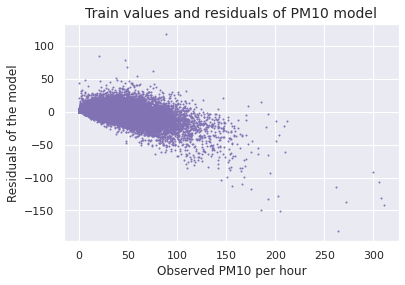

In [25]:
train_trans = pt_gases['PM10'].inverse_transform(y_train_pm10.values.reshape(-1,1))
pred_trans = pt_gases['PM10'].inverse_transform(y_train_pred.reshape(-1,1))
residuals = pred_trans - train_trans

plt.scatter(train_trans, residuals, s=1, color = 'm')
plt.xlabel("Observed PM10 per hour")
plt.ylabel("Residuals of the model")
plt.title("Train values and residuals of PM10 model", fontsize = 14)
#plt.savefig(IMAGES_FOLDER+"observed-vs-residuals-linear-regression.eps", bbox_inches = 'tight')
plt.show()

In [26]:
y_pred = pd.Series(y_pred, index = y_test_pm10.index)

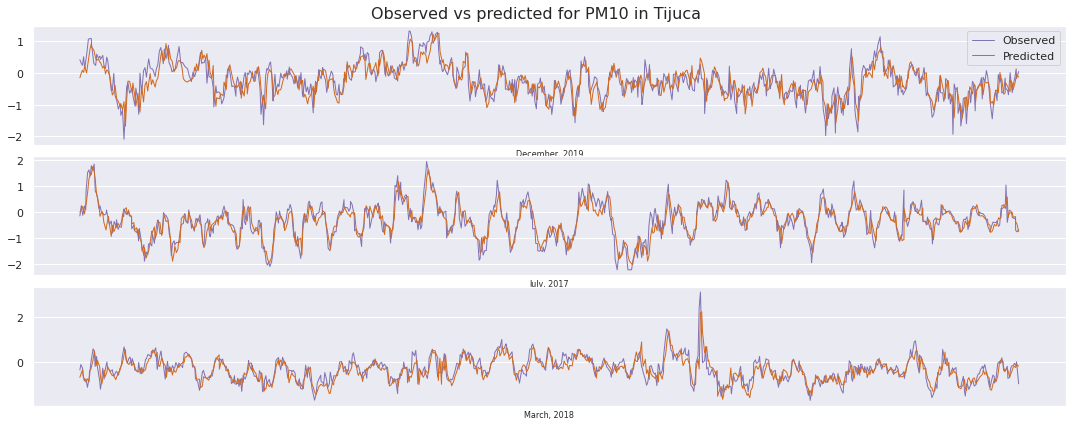

In [27]:
rows1 = x_test_SP[(x_test_SP.year==2019)&(x_test_SP.month==12)]
rows2 = x_test_SP[(x_test_SP.year==2017)&(x_test_SP.month==7)]
rows3 = x_test_SP[(x_test_SP.year==2018)&(x_test_SP.month==3)]

fig, ax = plt.subplots(3,1,figsize = (15,6))

ax[0].plot(rows1.index, y_test_pm10[rows1.index], linewidth = 1, label = 'Observed', color = 'm')
ax[0].plot(rows1.index, y_pred[rows1.index], linewidth = 1, label = 'Predicted', color = 'chocolate')
ax[1].plot(rows2.index, y_test_pm10[rows2.index], linewidth = 1, color = 'm')
ax[1].plot(rows2.index, y_pred[rows2.index], linewidth = 1, color = 'chocolate')
ax[2].plot(rows3.index, y_test_pm10[rows3.index], linewidth = 1, color = 'm')
ax[2].plot(rows3.index, y_pred[rows3.index], linewidth = 1, color = 'chocolate')

ax[0].set_xticks([], minor=False)
ax[1].set_xticks([], minor=False)
ax[2].set_xticks([], minor=False)

fig.suptitle("Observed vs predicted for PM10 in Tijuca", fontsize = 16)
fig.tight_layout(rect=[0, 0.03, 1, 1.02])

ax[0].set_xlabel("December, 2019", fontsize = 8)
ax[1].set_xlabel("July, 2017", fontsize = 8)
ax[2].set_xlabel("March, 2018", fontsize = 8)

ax[0].legend()

#plt.savefig(IMAGES_FOLDER+"observed-fitting-ozone-tijuca.eps", bbox_inches='tight')
del rows1,rows2,rows3

## Feature Selection + Linear regression

The Forward Feature Selection is performed with polynomial and interaction terms.

In [28]:
regr = LinearRegression()

best_features = utility.forward_selection(data = x_train_SP_poly, 
                                          target = y_train_pm10,
                                          regr = regr, 
                                          k_fold = 5, 
                                          threshold = 0.001
                                         )

In [29]:
print(best_features)

['PM10_lag1', 'year PM10_MA24', 'hour_cos', 'O3_lag1', 'year O3_lag2', 'hour_sin hour_cos', 'year Temp', 'RS O3_lag2', 'O3_lag1^2']


In [30]:
x_train_SP_sm = sm.add_constant(x_train_SP_poly[best_features])
x_test_SP_sm = sm.add_constant(x_test_SP_poly[best_features])

reg = sm.OLS(y_train_pm10, x_train_SP_sm)
res = reg.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                 2.466e+04
Date:                Mon, 21 Jun 2021   Prob (F-statistic):               0.00
Time:                        17:39:44   Log-Likelihood:                -28964.
No. Observations:               54290   AIC:                         5.795e+04
Df Residuals:                   54280   BIC:                         5.804e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0133      0.00

In [31]:
y_pred = res.predict(x_test_SP_sm)

y_train_pred = res.predict(x_train_SP_sm)

r2_train = r2_score(y_train_pm10, y_train_pred)
r2_test  = r2_score(y_test_pm10, y_pred)
mae_train = mean_absolute_error(y_train_pm10, y_train_pred)
mae_test  = mean_absolute_error(y_test_pm10, y_pred)
rmse_train = mean_squared_error(y_train_pm10, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_pm10, y_pred, squared = False)

utility.save_metrics("PM10", 8, "ffs_linear_regression", 
                     {'threshold': 0.001, 'best_features': best_features},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8035159249927369
MAE train set: 0.3082210293589973
RMSE train set: 0.4125335741414695
R2 test set: 0.7903629799033872
MAE test set: 0.2522292555379016
RMSE test set: 0.3292011507918209


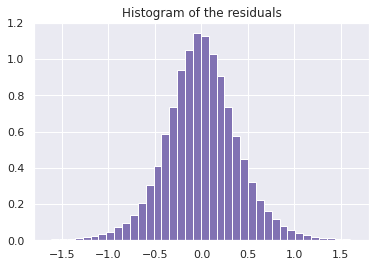

Skew: -0.019396982886944115
Kurt: 3.048730992576781
Jarque-Bera: Jarque_beraResult(statistic=21023.530663151934, pvalue=0.0)


In [32]:
residuals = y_train_pred - y_train_pm10
plt.hist(residuals, bins = 100, density = True, color = 'm')
plt.xlim((-1.8,1.8))
plt.title("Histogram of the residuals")
plt.show()

print("Skew: {}".format(residuals.skew()))
print("Kurt: {}".format(residuals.kurt()))
print("Jarque-Bera: {}".format(jarque_bera(residuals)))

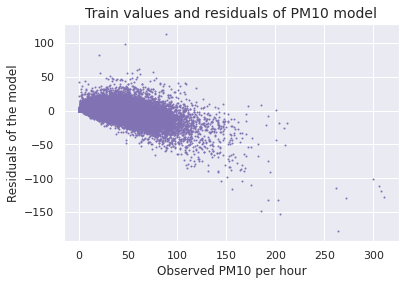

In [33]:
train_trans = pt_gases['PM10'].inverse_transform(y_train_pm10.values.reshape(-1,1))
pred_trans = pt_gases['PM10'].inverse_transform(y_train_pred.values.reshape(-1,1))
residuals = pred_trans - train_trans

plt.scatter(train_trans, residuals, s=1, color = 'm')
plt.xlabel("Observed PM10 per hour")
plt.ylabel("Residuals of the model")
plt.title("Train values and residuals of PM10 model", fontsize = 14)
#plt.savefig(IMAGES_FOLDER+"observed-vs-residuals-linear-regression.eps", bbox_inches = 'tight')
plt.show()

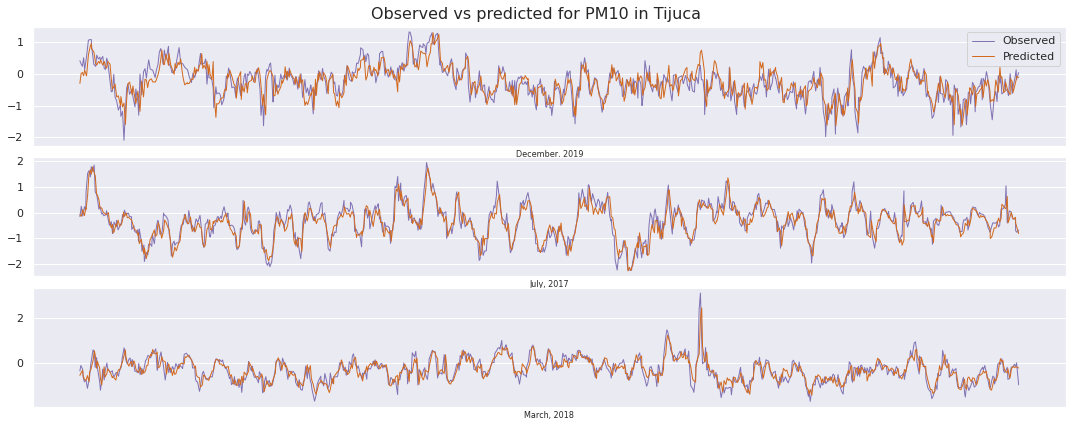

In [34]:
rows1 = x_test_SP[(x_test_SP.year==2019)&(x_test_SP.month==12)]
rows2 = x_test_SP[(x_test_SP.year==2017)&(x_test_SP.month==7)]
rows3 = x_test_SP[(x_test_SP.year==2018)&(x_test_SP.month==3)]

fig, ax = plt.subplots(3,1,figsize = (15,6))

ax[0].plot(rows1.index, y_test_pm10[rows1.index], linewidth = 1, label = 'Observed', color='m')
ax[0].plot(rows1.index, y_pred[rows1.index], linewidth = 1, label = 'Predicted', color='chocolate')
ax[1].plot(rows2.index, y_test_pm10[rows2.index], linewidth = 1, color='m')
ax[1].plot(rows2.index, y_pred[rows2.index], linewidth = 1, color='chocolate')
ax[2].plot(rows3.index, y_test_pm10[rows3.index], linewidth = 1, color='m')
ax[2].plot(rows3.index, y_pred[rows3.index], linewidth = 1, color = 'chocolate')

ax[0].set_xticks([], minor=False)
ax[1].set_xticks([], minor=False)
ax[2].set_xticks([], minor=False)

fig.suptitle("Observed vs predicted for PM10 in Tijuca", fontsize = 16)
fig.tight_layout(rect=[0, 0.03, 1, 1.02])

ax[0].set_xlabel("December, 2019", fontsize = 8)
ax[1].set_xlabel("July, 2017", fontsize = 8)
ax[2].set_xlabel("March, 2018", fontsize = 8)

ax[0].legend()

#plt.savefig(IMAGES_FOLDER+"observed-fitting-ozone-tijuca.eps", bbox_inches='tight')
del rows1,rows2,rows3

## Support vector machine

Considering the SVR with linear kernel. We make a grid search with cross-validation to estimate the best values from these above. 

In [35]:
scaler = StandardScaler()
svr = LinearSVR(epsilon = 0.1, 
                C = 1/2,
                max_iter = 2000)

pipe = Pipeline(steps=[('scaler', scaler), 
                       ('svr', svr)])

param_grid = {
    'svr__epsilon': [0.001, 0.01, 0.1, 0.2, 0.3],
    'svr__C': np.logspace(-3,2,6)
}

search = GridSearchCV(estimator = pipe, 
                      param_grid = param_grid,
                      scoring = 'neg_mean_squared_error',
                      cv = 5, 
                      verbose = 4, 
                      n_jobs=-1)

search.fit(x_train_SP, y_train_pm10)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameter (CV score=-0.161):
{'svr__C': 0.1, 'svr__epsilon': 0.01}


After the grid search with cross validation, the best parameters are used for the non linear kernel SRF to compare the waiting time.

In [36]:
epsilon = search.best_params_['svr__epsilon']
C = search.best_params_['svr__C']

In [37]:
%%time
svr = make_pipeline(StandardScaler(), 
                    SVR(kernel = 'rbf', 
                        degree = 2, 
                        epsilon = epsilon, 
                        C = C,
                        max_iter = 200000))

svr.fit(x_train_SP, y_train_pm10)

CPU times: user 2min 52s, sys: 75.3 ms, total: 2min 52s
Wall time: 2min 52s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=0.1, degree=2, epsilon=0.01, max_iter=200000))])

In [38]:
y_pred = svr.predict(x_test_SP)

y_train_pred = svr.predict(x_train_SP)

r2_train = r2_score(y_train_pm10, y_train_pred)
r2_test  = r2_score(y_test_pm10, y_pred)
mae_train = mean_absolute_error(y_train_pm10, y_train_pred)
mae_test  = mean_absolute_error(y_test_pm10, y_pred)
rmse_train = mean_squared_error(y_train_pm10, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_pm10, y_pred, squared = False)

utility.save_metrics("PM10", 8, "svr_rbf", 
                     {'epsilon': epsilon, 'C': C, 'degree': 2},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8344031758709924
MAE train set: 0.2749678096601541
RMSE train set: 0.3787229495031623
R2 test set: 0.7826658675327921
MAE test set: 0.255973971747894
RMSE test set: 0.33519020939033906


With the linear kernel.

In [39]:
%%time
svr = make_pipeline(StandardScaler(), 
                    LinearSVR(epsilon = epsilon, 
                              C = C,
                              max_iter = 10000))

svr.fit(x_train_SP, y_train_pm10)

CPU times: user 1.52 s, sys: 15.8 ms, total: 1.54 s
Wall time: 1.54 s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(C=0.1, epsilon=0.01, max_iter=10000))])

In [40]:
y_pred = svr.predict(x_test_SP)

y_train_pred = svr.predict(x_train_SP)

r2_train = r2_score(y_train_pm10, y_train_pred)
r2_test  = r2_score(y_test_pm10, y_pred)
mae_train = mean_absolute_error(y_train_pm10, y_train_pred)
mae_test  = mean_absolute_error(y_test_pm10, y_pred)
rmse_train = mean_squared_error(y_train_pm10, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_pm10, y_pred, squared = False)

utility.save_metrics("PM10", 8, "svr_linear", 
                     {'epsilon': epsilon, 'C': C},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.816873829944341
MAE train set: 0.29639470803896717
RMSE train set: 0.39826379470081186
R2 test set: 0.8002566450563156
MAE test set: 0.2469038258921885
RMSE test set: 0.3213390651568864


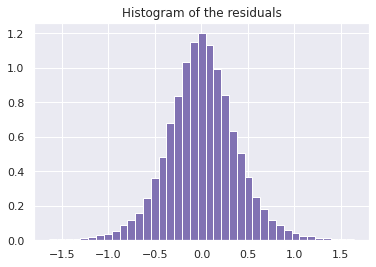

Skew: -0.06238791781117279
Kurt: 3.3435708625737246
Jarque-Bera: Jarque_beraResult(statistic=25317.771070592535, pvalue=0.0)


In [41]:
residuals = y_train_pred - y_train_pm10
plt.hist(residuals, bins = 100, density = True, color = 'm')
plt.xlim((-1.8,1.8))
plt.title("Histogram of the residuals")
plt.show()

print("Skew: {}".format(residuals.skew()))
print("Kurt: {}".format(residuals.kurt()))
print("Jarque-Bera: {}".format(jarque_bera(residuals)))

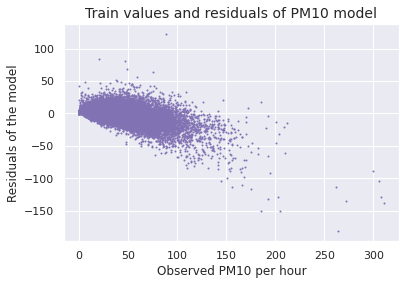

In [43]:
train_trans = pt_gases['PM10'].inverse_transform(y_train_pm10.values.reshape(-1,1))
pred_trans = pt_gases['PM10'].inverse_transform(y_train_pred.reshape(-1,1))
residuals = pred_trans - train_trans

plt.scatter(train_trans, residuals, s=1, color = 'm')
plt.xlabel("Observed PM10 per hour")
plt.ylabel("Residuals of the model")
plt.title("Train values and residuals of PM10 model", fontsize = 14)
#plt.savefig(IMAGES_FOLDER+"observed-vs-residuals-linear-regression.eps", bbox_inches = 'tight')
plt.show()

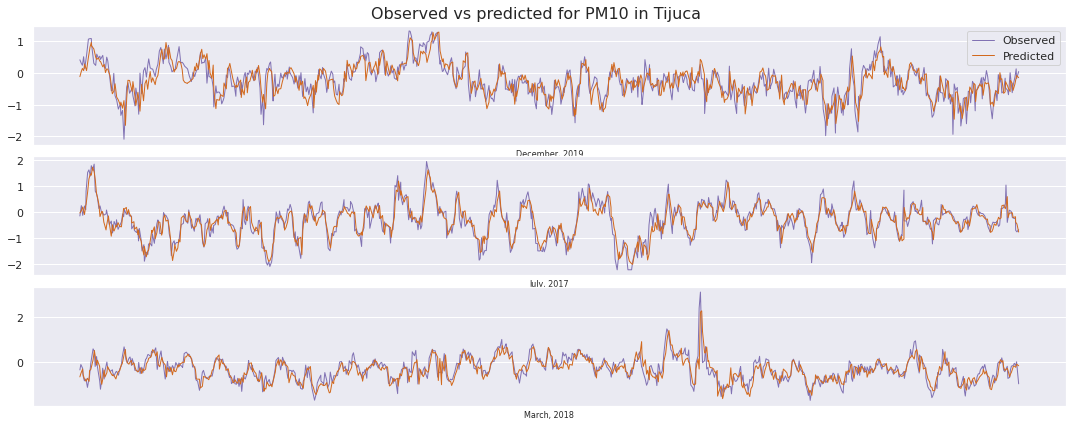

In [44]:
y_pred = pd.Series(y_pred, index = y_test_pm10.index)

rows1 = x_test_SP[(x_test_SP.year==2019)&(x_test_SP.month==12)]
rows2 = x_test_SP[(x_test_SP.year==2017)&(x_test_SP.month==7)]
rows3 = x_test_SP[(x_test_SP.year==2018)&(x_test_SP.month==3)]

fig, ax = plt.subplots(3,1,figsize = (15,6))

ax[0].plot(rows1.index, y_test_pm10[rows1.index], linewidth = 1, label = 'Observed', color = 'm')
ax[0].plot(rows1.index, y_pred[rows1.index], linewidth = 1, label = 'Predicted', color = 'chocolate')
ax[1].plot(rows2.index, y_test_pm10[rows2.index], linewidth = 1, color = 'm')
ax[1].plot(rows2.index, y_pred[rows2.index], linewidth = 1, color = 'chocolate')
ax[2].plot(rows3.index, y_test_pm10[rows3.index], linewidth = 1, color = 'm')
ax[2].plot(rows3.index, y_pred[rows3.index], linewidth = 1, color = 'chocolate')

ax[0].set_xticks([], minor=False)
ax[1].set_xticks([], minor=False)
ax[2].set_xticks([], minor=False)

fig.suptitle("Observed vs predicted for PM10 in Tijuca", fontsize = 16)
fig.tight_layout(rect=[0, 0.03, 1, 1.02])

ax[0].set_xlabel("December, 2019", fontsize = 8)
ax[1].set_xlabel("July, 2017", fontsize = 8)
ax[2].set_xlabel("March, 2018", fontsize = 8)

ax[0].legend()

#plt.savefig(IMAGES_FOLDER+"observed-fitting-ozone-tijuca.eps", bbox_inches='tight')
del rows1,rows2,rows3

Considering the best features selected by Linear Regression. 

In [45]:
%%time
svr = make_pipeline(StandardScaler(), 
                    LinearSVR(epsilon = epsilon, 
                              C = C,
                              max_iter = 10000))

svr.fit(x_train_SP_poly[best_features], y_train_pm10)

CPU times: user 665 ms, sys: 0 ns, total: 665 ms
Wall time: 665 ms


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(C=0.1, epsilon=0.01, max_iter=10000))])

In [46]:
y_pred = svr.predict(x_test_SP_poly[best_features])

y_train_pred = svr.predict(x_train_SP_poly[best_features])

r2_train = r2_score(y_train_pm10, y_train_pred)
r2_test  = r2_score(y_test_pm10, y_pred)
mae_train = mean_absolute_error(y_train_pm10, y_train_pred)
mae_test  = mean_absolute_error(y_test_pm10, y_pred)
rmse_train = mean_squared_error(y_train_pm10, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_pm10, y_pred, squared = False)

utility.save_metrics("PM10", 8, "svr_linear_best_features", 
                     {'epsilon': epsilon, 'C': C},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8030294590247822
MAE train set: 0.3077879296070357
RMSE train set: 0.41304394497476216
R2 test set: 0.7930417396426347
MAE test set: 0.2497868904385924
RMSE test set: 0.32709110834042454


In [47]:
%%time
svr = make_pipeline(StandardScaler(), 
                    SVR(kernel = 'rbf', 
                        degree = 2, 
                        epsilon = epsilon, 
                        C = C,
                        max_iter = 200000))

svr.fit(x_train_SP_poly[best_features], y_train_pm10)

CPU times: user 2min 24s, sys: 35.9 ms, total: 2min 24s
Wall time: 2min 24s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=0.1, degree=2, epsilon=0.01, max_iter=200000))])

In [48]:
y_pred = svr.predict(x_test_SP_poly[best_features])

y_train_pred = svr.predict(x_train_SP_poly[best_features])

r2_train = r2_score(y_train_pm10, y_train_pred)
r2_test  = r2_score(y_test_pm10, y_pred)
mae_train = mean_absolute_error(y_train_pm10, y_train_pred)
mae_test  = mean_absolute_error(y_test_pm10, y_pred)
rmse_train = mean_squared_error(y_train_pm10, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_pm10, y_pred, squared = False)

utility.save_metrics("PM10", 8, "svr_rbf_best_features", 
                     {'epsilon': epsilon, 'C': C},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8106483289235868
MAE train set: 0.2991663772458733
RMSE train set: 0.4049768446377283
R2 test set: 0.7975456857055025
MAE test set: 0.24653404453422476
RMSE test set: 0.32351235702667336


## Random Forest

In [49]:
scaler = StandardScaler()
rand_forest = RandomForestRegressor(n_estimators = 100, 
                                    criterion = 'mse', 
                                    min_samples_split = 10, 
                                    max_features = 'sqrt',
                                    ccp_alpha = 0.0,
                                    n_jobs=2,
                                    )

pipe = Pipeline(steps=[('scaler', scaler), 
                       ('forest', rand_forest)])

param_grid = {
    'forest__min_samples_split': [10, 20, 50, 100],
    'forest__ccp_alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 1]
}

search = GridSearchCV(estimator = pipe, 
                      param_grid = param_grid,
                      scoring = 'neg_mean_squared_error',
                      cv = 5, 
                      verbose = 4, 
                      n_jobs=2)

search.fit(x_train_SP, y_train_pm10)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameter (CV score=-0.188):
{'forest__ccp_alpha': 0.0, 'forest__min_samples_split': 10}


In [50]:
B = 100
c = search.best_params_['forest__ccp_alpha']
s = search.best_params_['forest__min_samples_split']

In [51]:
rand_forest = RandomForestRegressor(n_estimators = 500, 
                                    criterion = 'mse', 
                                    min_samples_split = s, 
                                    max_features = 'sqrt',
                                    ccp_alpha = c,
                                    n_jobs = 2,
                                    )
rand_forest.fit(x_train_SP, y_train_pm10)

RandomForestRegressor(max_features='sqrt', min_samples_split=10,
                      n_estimators=500, n_jobs=2)

In [52]:
y_pred = rand_forest.predict(x_test_SP)

y_train_pred = rand_forest.predict(x_train_SP)

r2_train = r2_score(y_train_pm10, y_train_pred)
r2_test  = r2_score(y_test_pm10, y_pred)
mae_train = mean_absolute_error(y_train_pm10, y_train_pred)
mae_test  = mean_absolute_error(y_test_pm10, y_pred)
rmse_train = mean_squared_error(y_train_pm10, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_pm10, y_pred, squared = False)

utility.save_metrics("PM10", 8, "random_forest", 
                     {'s': s, 'c': c, 'B': 100},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.9427199533886547
MAE train set: 0.16384021309385866
RMSE train set: 0.22273953183487008
R2 test set: 0.8031327639151692
MAE test set: 0.2445021392108946
RMSE test set: 0.3190171845242635


Changing the grid a little. 

In [53]:
rand_forest = RandomForestRegressor(n_estimators = 100, 
                                    criterion = 'mse', 
                                    min_samples_split = 10, 
                                    max_features = 'sqrt',
                                    ccp_alpha = 0.0,
                                    n_jobs=2,
                                    verbose=4,
                                    )

pipe = Pipeline(steps=[('scaler', scaler), 
                       ('forest', rand_forest)])

param_grid = {
    'forest__min_samples_split': [2, 5, 8],
    'forest__ccp_alpha': [0.0, 0.01, 1.]
}

search = GridSearchCV(estimator = pipe, 
                      param_grid = param_grid,
                      scoring = 'neg_mean_squared_error',
                      cv = 5, 
                      verbose = 4, 
                      n_jobs=2)

search.fit(x_train_SP, y_train_pm10)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    2.2s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66

[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:    9.7s


building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
Best parameter (CV score=-0.188):
{'forest__ccp_alpha': 0.0, 'forest__min_samples_split': 5}


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   10.3s finished


In [54]:
B = 100
c = search.best_params_['forest__ccp_alpha']
s = search.best_params_['forest__min_samples_split']

In [55]:
rand_forest = RandomForestRegressor(n_estimators = 500, 
                                    criterion = 'mse', 
                                    min_samples_split = s, 
                                    max_features = 'sqrt',
                                    ccp_alpha = c,
                                    n_jobs = 2,
                                    )
rand_forest.fit(x_train_SP, y_train_pm10)

RandomForestRegressor(max_features='sqrt', min_samples_split=5,
                      n_estimators=500, n_jobs=2)

In [56]:
y_pred = rand_forest.predict(x_test_SP)

y_train_pred = rand_forest.predict(x_train_SP)

r2_train = r2_score(y_train_pm10, y_train_pred)
r2_test  = r2_score(y_test_pm10, y_pred)
mae_train = mean_absolute_error(y_train_pm10, y_train_pred)
mae_test  = mean_absolute_error(y_test_pm10, y_pred)
rmse_train = mean_squared_error(y_train_pm10, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_pm10, y_pred, squared = False)

utility.save_metrics("PM10", 8, "random_forest", 
                     {'s': s, 'c': c, 'B': 100},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.9643297651503289
MAE train set: 0.12724260288227643
RMSE train set: 0.17577155932329033
R2 test set: 0.8027543425811594
MAE test set: 0.24480996416619458
RMSE test set: 0.3193236472774269


In [57]:
rand_forest = RandomForestRegressor(n_estimators = 500, 
                                    criterion = 'mse', 
                                    min_samples_split = 10, 
                                    max_features = 'sqrt',
                                    ccp_alpha = 0.0,
                                    n_jobs = 2,
                                    )
rand_forest.fit(x_train_SP_poly[best_features], y_train_pm10)

RandomForestRegressor(max_features='sqrt', min_samples_split=10,
                      n_estimators=500, n_jobs=2)

In [58]:
y_pred = rand_forest.predict(x_test_SP_poly[best_features])

y_train_pred = rand_forest.predict(x_train_SP_poly[best_features])

r2_train = r2_score(y_train_pm10, y_train_pred)
r2_test  = r2_score(y_test_pm10, y_pred)
mae_train = mean_absolute_error(y_train_pm10, y_train_pred)
mae_test  = mean_absolute_error(y_test_pm10, y_pred)
rmse_train = mean_squared_error(y_train_pm10, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_pm10, y_pred, squared = False)

utility.save_metrics("PM10", 8, "random_forest_best_features", 
                     {'s': 10, 'c': 0, 'B': 500},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.9312209543654763
MAE train set: 0.18070922934534236
RMSE train set: 0.2440752224617544
R2 test set: 0.791210777034338
MAE test set: 0.2520747432103217
RMSE test set: 0.328534812047809


## Linear Regression + Expectation Maximization

For this model, we asked for help from `R`. 

In [59]:
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector, r

norm = importr("norm")

Training the model with normal variables

In [61]:
df_train = utility.linear_regression_em_preparation(location, gas_name='PM10')

In [62]:
X_r = FloatVector(df_train.values.flatten())
m = r['matrix'](X_r, ncol = df_train.shape[1], byrow = True)

s = norm.prelim_norm(m)  
theta = norm.em_norm(s)
params = norm.getparam_norm(s,theta,corr=False)
params = dict(zip(params.names, map(np.array,list(params))))

Iterations of EM: 
1...2...3...4...5...6...7...8...


In [63]:
mu_y = params['mu'][-1]
mu_X = params['mu'][:-1].reshape(-1,1)

Sigma_XX = params['sigma'][:-1,:-1]
Sigma_yX = params['sigma'][-1,:-1].reshape(1,-1)
Sigma_Xy = params['sigma'][:-1,-1].reshape(-1,1)
Sigma_yy = params['sigma'][-1,-1]

inv_Sigma_XX = np.linalg.inv(Sigma_XX)

beta = np.hstack([mu_y - Sigma_yX@inv_Sigma_XX@mu_X, Sigma_yX@inv_Sigma_XX]).reshape(-1,1)

In [65]:
diff_regression = pd.DataFrame({'linear-regression': resl.params.values, 
                                'linear-regression-em': beta.flatten(), 
                                'ratio': resl.params.values/beta.flatten()},
                                 index = resl.params.index)

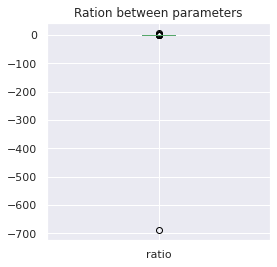

In [66]:
diff_regression.ratio.plot.box(figsize = (4,4), title = 'Ration between parameters');
#plt.savefig(IMAGES_FOLDER+'boxplot_ratio_linear_regression.eps', bbox_inches = 'tight')

In [68]:
y_pred = x_test_SP@beta[1:] + beta[0]

y_train_pred = x_train_SP@beta[1:] + beta[0]

r2_train = r2_score(y_train_pm10, y_train_pred)
r2_test  = r2_score(y_test_pm10, y_pred)
mae_train = mean_absolute_error(y_train_pm10, y_train_pred)
mae_test  = mean_absolute_error(y_test_pm10, y_pred)
rmse_train = mean_squared_error(y_train_pm10, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_pm10, y_pred, squared = False)

utility.save_metrics("PM10", 8, "linear_regression_em", 
                     {},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8170649441611744
MAE train set: 0.29715863487620814
RMSE train set: 0.39805592233046166
R2 test set: 0.7935585528979003
MAE test set: 0.25170378547655436
RMSE test set: 0.32668244940029667


In [69]:
df_train_2 = pd.DataFrame()

for feat in best_features: 
    feats = feat.split()
    if len(feats) == 2: 
        df_train_2[feat] = df_train[feats[0]]*df_train[feats[1]]
    elif feats[0][-2] == '^': 
        df_train_2[feat] = df_train[feats[0][:-2]]**2
    else: 
        df_train_2[feat] = df_train[feats[0]]
        
df_train_2['PM10'] = df_train['PM10']

In [70]:
X_r = FloatVector(df_train_2.values.flatten())
m = r['matrix'](X_r, ncol = df_train_2.shape[1], byrow = True)

s = norm.prelim_norm(m)  
theta = norm.em_norm(s)
params = norm.getparam_norm(s,theta,corr=False)
params = dict(zip(params.names, map(np.array,list(params))))

Iterations of EM: 
1...2...3...4...5...6...


In [71]:
mu_y = params['mu'][-1]
mu_X = params['mu'][:-1].reshape(-1,1)

Sigma_XX = params['sigma'][:-1,:-1]
Sigma_yX = params['sigma'][-1,:-1].reshape(1,-1)
Sigma_Xy = params['sigma'][:-1,-1].reshape(-1,1)
Sigma_yy = params['sigma'][-1,-1]

inv_Sigma_XX = np.linalg.inv(Sigma_XX)

beta = np.hstack([mu_y - Sigma_yX@inv_Sigma_XX@mu_X, Sigma_yX@inv_Sigma_XX]).reshape(-1,1)

In [72]:
y_pred = x_test_SP_poly[best_features]@beta[1:] + beta[0]

y_train_pred = x_train_SP_poly[best_features]@beta[1:] + beta[0]

r2_train = r2_score(y_train_pm10, y_train_pred)
r2_test  = r2_score(y_test_pm10, y_pred)
mae_train = mean_absolute_error(y_train_pm10, y_train_pred)
mae_test  = mean_absolute_error(y_test_pm10, y_pred)
rmse_train = mean_squared_error(y_train_pm10, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_pm10, y_pred, squared = False)

utility.save_metrics("PM10", 8, "linear_regression_em_best_features", 
                     {},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8034287640614639
MAE train set: 0.30837343376091586
RMSE train set: 0.41262506456823544
R2 test set: 0.7895960395978175
MAE test set: 0.25275460263925564
RMSE test set: 0.3298027791091462


## Model comparison

In [9]:
import json 

with open('../data/models.json', 'r') as f: 
    models = json.load(f)
    models_pm10 = {key: value for (key,value) in models.items() if value['gas'] == 'PM10' and value['station'] == 8}

In [10]:
df_models = pd.DataFrame()
for i in models_pm10.keys():
    df_models = df_models.append(pd.json_normalize(models_pm10[i]), ignore_index = True)

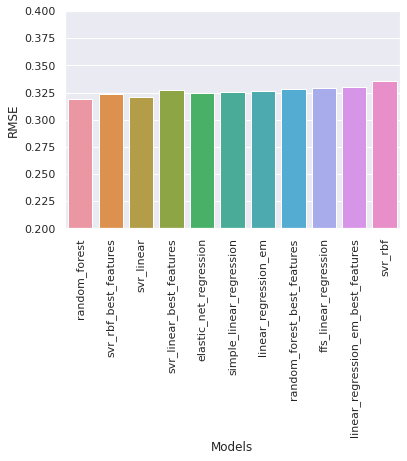

In [15]:
df_models = df_models.sort_values(by = 'mae_test')
sns.barplot(x = 'model_name', y = 'rmse_test', data = df_models)
plt.xticks(rotation=90)
plt.ylabel('RMSE')
plt.ylim(0.2,0.4)
plt.xlabel('Models');
plt.savefig(IMAGES_FOLDER+'model-comparison-pm10-tijuca.eps', bbox_inches = 'tight')